# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift
from darwinian_shift import CDFMonteCarloTest, BinomTest
from darwinian_shift import FoldXLookup, MutationExclusionLookup, StructureDistanceLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes
from darwinian_shift import UniprotLookup, get_bins_for_uniprot_features, plot_domain_structure

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Setup

In [3]:
# Define the region to test
p53_dbd_section = {
    'transcript_id': 'ENST00000269305', 'pdb_id': '2ac0', 'pdb_chain': 'A', 
    # Lys292 is missing the alpha-carbon in chain A of the structure. 
    # For consistency between tests, exclude from all
    'excluded_residues': [292],  
    'DNA_target': 'segid E F G H'
}

In [4]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense',
    statistics=CDFMonteCarloTest(num_draws=100000)
)

In [5]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',
    included_mutation_types='missense', 
    statistics=CDFMonteCarloTest(num_draws=100000)
)

In [6]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"
 
# Colours
unobserved_colour = '#BBBBBB'
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Missense mutation distribution

In [7]:
tp53_skin = d_skin.make_section(gene='TP53')
tp53_oe = d_oe.make_section(gene='TP53')

In [8]:
last_residue = tp53_skin.null_mutations['residue'].max()

u = UniprotLookup()
TP53_uniprot = u.get_uniprot_data('ENST00000269305')

bins, types, descriptions = get_bins_for_uniprot_features(TP53_uniprot, min_gap=1, last_residue=last_residue, 
                                                         feature_types=['DNA-binding region'])
colours = []
for t, desc in zip(types, descriptions):
    if t == 'DNA-binding region':
        colours.append('#88CCEE')
    else:
        colours.append(None)

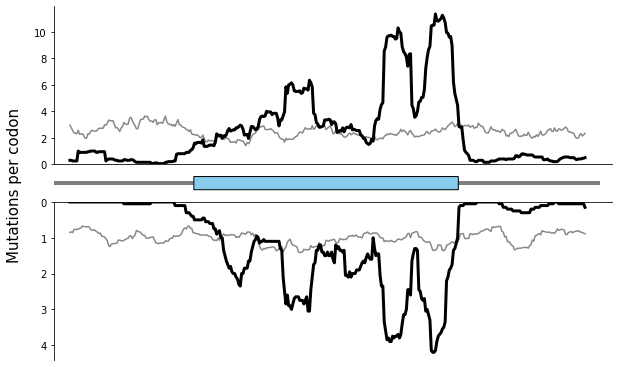

In [9]:
fig, (ax1, ax_dom, ax2) = plt.subplots(3, 1, figsize=(10, 6.5), sharex=True, 
                                       gridspec_kw={'height_ratios': (3, 0.5, 3), 'hspace': 0.05})
linewidth = 1.3
tp53_skin.plot_sliding_window(figsize=(10, 3), ax=ax1, show_legend=False, colours=['k', '#888888'])
ax1.set_xlim([0, last_residue+10])
hide_top_and_right_axes(ax1)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

tp53_oe.plot_sliding_window(figsize=(10, 3), ax=ax2, show_legend=False, colours=['k', '#888888'])
ax2.set_xlim([0, last_residue+10])
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
# hide_top_and_right_axes(plt.gca())
ax2.invert_yaxis()
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

plot_domain_structure(bins, colours, height=1, ax=ax_dom)
ax_dom.set_xlim([0, last_residue+10])

fig.text(0.06, 0.5, 'Mutations per codon', va='center', rotation='vertical', fontsize=15);

# Lookups

In [10]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

In [11]:
# Define a lookup object which measures distance from the DNA
interface_lookup = StructureDistanceLookup(
    boolean=False,  
    target_key='DNA_target',   # Use this entry in the section_definition dict to define the target residues
    name='Distance from DNA (A)',  # Label to appear on plot axes
    distance_to_alpha_carbons=True,
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory
)

In [12]:
# For testing ∆∆G distribution excluding mutations close to DNA
excllook_foldx = MutationExclusionLookup(
    lookup=fold,  
    exclusion_lookup=interface_lookup,
    exclusion_threshold=5,  
    exclusion_direction=-1,  
    name=fold.name
)

In [13]:
# For testing the distance from DNA excluding high ∆∆G mutations
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,
    exclusion_lookup=fold,
    exclusion_threshold=2,  
    exclusion_direction=1,  
    name=interface_lookup.name
)

# Skin

In [14]:
s = d_skin.run_section(p53_dbd_section, lookup=excllook_foldx)

In [15]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 760,
 'observed_median': 3.18563,
 'observed_mean': 5.719232957589474,
 'expected_median_glob_k3': 1.42978,
 'median_shift_glob_k3': 1.7558500000000001,
 'expected_mean_glob_k3': 2.5710626339454765,
 'mean_shift_glob_k3': 3.1481703236439977,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.6910438087121998}

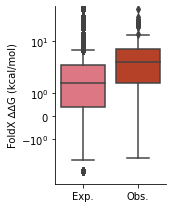

In [16]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

In [17]:
s = d_skin.run_section(p53_dbd_section, lookup=excllook_interface)

In [18]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 395,
 'observed_median': 8.328342859935441,
 'observed_mean': 10.452537714531719,
 'expected_median_glob_k3': 15.73809557526036,
 'median_shift_glob_k3': -7.4097527153249185,
 'expected_mean_glob_k3': 16.041669936926223,
 'mean_shift_glob_k3': -5.589132222394504,
 'CDF_MC_glob_k3_num_smaller_or_equal': 1,
 'CDF_MC_glob_k3_num_larger_or_equal': 100001,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.2914370531010195}

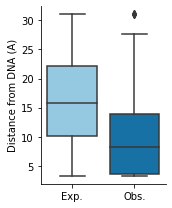

In [19]:
s.plot_boxplot(figsize=(2.5, 3),
                    colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

# Oesophagus

In [20]:
s = d_oe.run_section(p53_dbd_section, lookup=excllook_foldx)

In [21]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 338,
 'observed_median': 3.38316,
 'observed_mean': 5.553799265088758,
 'expected_median_glob_k3': 1.26027,
 'median_shift_glob_k3': 2.12289,
 'expected_mean_glob_k3': 2.9833941693821937,
 'mean_shift_glob_k3': 2.570405095706564,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.6725791625235596}

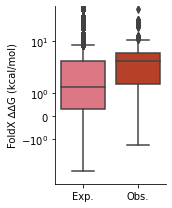

In [22]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

In [23]:
s = d_oe.run_section(p53_dbd_section, lookup=excllook_interface)

In [24]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 154,
 'observed_median': 8.328342859935441,
 'observed_mean': 10.96319060828938,
 'expected_median_glob_k3': 14.404536580544768,
 'median_shift_glob_k3': -6.076193720609327,
 'expected_mean_glob_k3': 14.781657648898392,
 'mean_shift_glob_k3': -3.8184670406090113,
 'CDF_MC_glob_k3_num_smaller_or_equal': 1,
 'CDF_MC_glob_k3_num_larger_or_equal': 100001,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.34184526359951234}

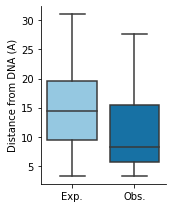

In [25]:
s.plot_boxplot(figsize=(2.5, 3),
                    colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

# Total mutations

Count the total mutations in the two categories.  
The expected and observed proportions are calculated as part of the binomial test.  

In [26]:
combined_lookup = ORLookup(lookups=[fold, interface_lookup], 
                          thresholds=[2, 5],   # Over 2kcal/mol or under 5A from DNA
                          directions=[1, -1])

## Skin

In [27]:
s = d_skin.run_section(p53_dbd_section, lookup=combined_lookup, statistics=BinomTest())

In [28]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 898,
 'observed_median': 1.0,
 'observed_mean': 0.7060133630289532,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.4252091738752974,
 'mean_shift_glob_k3': 0.28080418915365585,
 'binom_glob_k3_pvalue': 1.1428219454970764e-64,
 'binom_glob_k3_expected_proportion': 0.42520917387529733,
 'binom_glob_k3_observed_proportion': 0.7060133630289532,
 'binom_glob_k3_expected_count': 381.837838140017,
 'binom_glob_k3_observed_count': 634,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 411.0,
 'binom_glob_k3_expected_CI_low': 353.0,
 'binom_glob_k3_observed_CI_low': 607.0,
 'binom_glob_k3_observed_CI_high': 661.0}

## Oesophagus

In [29]:
s = d_oe.run_section(p53_dbd_section, lookup=combined_lookup, statistics=BinomTest())

In [30]:
s.get_results_dictionary()

{'gene': 'TP53',
 'transcript_id': 'ENST00000269305',
 'chrom': '17',
 'section_id': '2ac0:A',
 'num_mutations': 380,
 'observed_median': 1.0,
 'observed_mean': 0.6894736842105263,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.41812147696554014,
 'mean_shift_glob_k3': 0.2713522072449862,
 'binom_glob_k3_pvalue': 2.298120992479256e-26,
 'binom_glob_k3_expected_proportion': 0.41812147696554014,
 'binom_glob_k3_observed_proportion': 0.6894736842105263,
 'binom_glob_k3_expected_count': 158.88616124690526,
 'binom_glob_k3_observed_count': 262,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 178.0,
 'binom_glob_k3_expected_CI_low': 140.0,
 'binom_glob_k3_observed_CI_low': 244.0,
 'binom_glob_k3_observed_CI_high': 280.0}